# Imports

In [18]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, TimeDistributed, LSTM, Lambda, Bidirectional, RepeatVector, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ProgbarLogger, History
import tensorflow as tf
import keras.backend as K
from IPython.display import display
from tensorflow.keras.metrics import get as metric_get
import re
import talos
from copy import deepcopy, copy
import time
import util
import functools 
import itertools
import networkx as nx
from typing import List, Iterator, Tuple, Dict, Union
import json
import inspect
import os

# Set up GPU:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)
# remove warnings from tensorflow
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(1)

# Load data
load hospitalisations and trends

In [2]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

# hospitalisations features given as input
list_hosp_features = [
    'NEW_HOSP',
    'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
]

europe = False  # if True, use european countries. Otherwise, use french regions and belgium

Additional information: what is the target, should some features remain unscaled?

In [3]:
# target, should be one of the hosp features
target = 'TOT_HOSP'

cumsum = False  # if True, the target will be accumulated over each day

# features that should not be scaled
unscaled = [
    #'NEW_HOSP',
    #'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
    #'Fièvre',
    #'Mal de gorge',
    #'Dyspnée',
    #'Agueusie',
    #'Anosmie',
    #'Coronavirus',
    #'Virus',
    #'Température corporelle humaine',
    #'Épidémie',
    #'Symptôme',
    #'Thermomètre',
    #'Grippe espagnole',
    #'Paracétamol',
    #'Respiration',
    #'Toux',
]

Type of prediction: how many days as input sould be used to predict how many days as output? Should we give a prediction on all days or only on the last?

In [4]:
date_begin = "2020-02-01"
n_forecast = 20
n_samples = 30
predict_one = False

In [5]:
validation_metrics = [metric_get("MeanSquaredError"), metric_get('MeanAbsoluteError'), 
                      metric_get('RootMeanSquaredError')]

url_world = "../data/hospi/world.csv"
url_pop = "../data/population.txt"
url_trends = "../data/trends/model/"
url_hospi_belgium = "../data/hospi/be-covid-hospi.csv"
url_department_france = "france_departements.csv"
url_hospi_france_new = "../data/hospi/fr-covid-hospi.csv"
url_hospi_france_tot = "../data/hospi/fr-covid-hospi-total.csv"
if europe:
    population = util.get_world_population(url_pop)
    renaming = {v: k for k, v in util.european_geocodes.items()}
    geocodes = {k: v for k, v in util.european_geocodes.items() if population[k] > 1_000_000}
    df_hospi = util.hospi_world(url_world, geocodes, renaming, new_hosp=True, date_begin=date_begin)
    augment_population = {k: v/1000 for k, v in population.items()}
else:
    geocodes = util.french_region_and_be
    population = pd.read_csv(url_department_france).groupby('regionTrends').agg({'population': 'sum'})
    augment_population = {k: pop['population'] / 100_000 for k, pop in population.iterrows()}  # pop per 100.000
    df_hospi = util.hospi_french_region_and_be(url_hospi_france_tot, url_hospi_france_new, url_hospi_belgium, 
                                           url_department_france, util.french_region_and_be, new_hosp=True, 
                                           tot_hosp=True, date_begin=date_begin)
df_trends = util.create_df_trends(url_trends, list_topics, geocodes)  # TODO deal with augmented data
for k in df_hospi.keys(): # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
    
scaler_generator = MinMaxScaler
dg = util.DataGenerator(merged_df, n_samples, n_forecast, target, scaler_generator=scaler_generator, scaler_type='batch',
                       augment_merge=3, augment_adjacency=util.france_region_adjacency, augment_population=augment_population,
                       predict_one=predict_one, cumsum=cumsum, data_columns=list_hosp_features)
n_features = dg.n_features
target_idx = dg.target_idx

### Encoder decoder model

In [6]:
if not predict_one:
    weights_loss = np.array([(1/x) for x in range(1, n_forecast+1)])
else:
    weights_loss = 1

def custom_loss_function(y_true, y_pred):
    y_true = y_true * weights_loss
    y_pred = y_pred * weights_loss
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

def get_encoder_decoder(batch_input_shape):
    model = Sequential()
    #model.add(Bidirectional(LSTM(8, return_sequences=True, stateful=False), 
    #                        input_shape=(n_samples, n_features), merge_mode="ave"))
    model.add(LSTM(16, return_sequences=True, stateful=False, batch_input_shape=batch_input_shape, recurrent_dropout=0))
    model.add(LSTM(4, return_sequences=False, stateful=False))
    model.add(RepeatVector(n_forecast))  # repeat
    model.add(LSTM(4, return_sequences=True, stateful=False))  # dec
    if not predict_one:
        model.add(LSTM(16, return_sequences=True, stateful=False))  # dec
        model.add(TimeDistributed(Dense(1)))
        model.add(Reshape((n_forecast,)))
    else:
        model.add(LSTM(16, return_sequences=False, stateful=False))  # dec
        model.add(Dense(1))
        model.add(Reshape((1,)))
    model.compile(loss=custom_loss_function, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model
    
get_encoder_decoder((1, n_samples, n_features)).output_shape

(1, 20)

### Variation of encoder decoder

In [7]:
def get_simple_autoencoder(batch_input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: x[:,:,target_idx:target_idx+1], batch_input_shape=batch_input_shape))
    model.add(LSTM(32, return_sequences=False, stateful=False))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model
get_simple_autoencoder((1, n_samples, n_features)).output_shape

(1, 20)

## Models to beat
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [8]:
class MultiStepLastLayer(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs, *args, **kwargs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # target of the last days
        # a = tf.where(tf.not_equal(a, 0), tf.zeros_like(a), a)
        if not predict_one:
            return tf.tile(
                a,
                [1, n_forecast, 1]   # repeat target n_forecast time
            )
        else:
            return tf.tile(a, [1, 1, 1])
        
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def __init__(self, batch_input_shape=None, *args, **kwargs):
        super(MultiStepLastBaseline, self).__init__(name='')
        self.total = tf.Variable(initial_value=tf.zeros((1,)), trainable=False)
        self.multi_step = MultiStepLastLayer()
        self.reshape = Reshape((n_forecast,))
    
    def call(self, input_tensor, training=False):
        x = self.multi_step(input_tensor)
        return self.reshape(x)
        
    def get_weights(self):
        return None
    
    def set_weights(self, *args, **kwargs):
        return None

def get_baseline(*args, **kwargs):
    model = MultiStepLastBaseline(*args, **kwargs)
    model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

### Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [9]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs, *args, **kwargs):
        y = inputs[:, :, target_idx]  # target of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the target
        if not predict_one:
            result = np.zeros((length, n_forecast))
            for i in range(length):
                regr = LinearRegression().fit(x, y[i])  # linear regression of (days, target)
                result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        else:
            result = np.zeros((length, 1))
            for i in range(length):
                regr = LinearRegression().fit(x, y[i])
                result[i] = regre.predict([n_samples+n_forecast-1])
        return result
        
def get_custom_linear_regression(*args, **kwargs):
    model = LinearRegressionHospi()
    model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

### 1 fully connected layer (Dense model)
Using only the target in the fit

In [10]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,target_idx]))  # select only the target of the previous days
if not predict_one:
    DenseModel.add(Dense(n_forecast))   # predict the next target based on the previous ones
else:
    DenseModel.add(Dense(1))
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

def get_dense_model(batch_input_shape, use_lambda=True):
    model = Sequential()
    if use_lambda:
        model.add(Lambda(lambda x: x[:,:,target_idx], batch_input_shape=batch_input_shape))  # select only the target of the previous days
        model.add(Dense(n_forecast))   # predict the next target based on the previous ones
    else:
        model.add(Dense(1, batch_input_shape=batch_input_shape))
        model.add(Reshape((n_samples,)))
        model.add(Dense(n_forecast))
    model.compile(loss=tf.losses.MeanSquaredError(),
                          metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

# Metrics and plot functions

In [11]:
def plot_prediction_vs_actual(df_y_real, df_y_predicted, prediction_dates, cur_loc, horizon=1, mode=0):
    """
    plot the prediction done on a specific horizon along with the last points of data before
    """
    if not predict_one:
        if mode == 0:
            horizon_range = range(horizon, horizon+1)
        elif mode == 1:
            horizon_range = range(1, horizon+1)
    else:
        horizon_range = [1]

    df_real = df_y_real[cur_loc]
    df_pred = df_y_predicted[cur_loc]
    prediction_dates = prediction_dates[:, horizon]
    
    for horizon in horizon_range:
        fig = plt.figure(figsize=(6,3))
        expected = df_real[f"{target}(t+{horizon})"].values
        plt.plot(prediction_dates, expected, marker=".", label="True value")
        prediction = df_pred[f"{target}(t+{horizon})"].values

        if not predict_one:
            plot_label = f"Prediction horizon {horizon}"
        else:
            plot_label = f"Prediction horizon {n_forecast}"
        plt.plot(prediction_dates, prediction, marker='.', label=plot_label)

        ax = fig.axes[0]
        # set locator
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        plt.title(f"Plot true and predicted values for {cur_loc}")
        plt.legend()
        plt.grid()
        plt.show()
        
def compute_error(Y_expected, Y_actual) -> pd.DataFrame:
    MAE = mean_absolute_error(Y_expected, Y_actual, multioutput="raw_values")
    MSE = mean_squared_error(Y_expected, Y_actual, multioutput="raw_values")
    values = {}
    for t in range(n_forecast):
        values[f'MAE(t+{t+1})'] = [MAE[t]]
        values[f'MSE(t+{t+1})'] = [MSE[t]]
    return pd.DataFrame(values)

# Simple prediction
use a percentage of values for training and the remaining values for testing

In [12]:
# X% for training, remaining for test
ratio_training = 0.9
nb_datapoints = dg.batch_size
max_train = int(ratio_training * nb_datapoints)
train_idx = np.array(range(max_train))
test_idx = np.array(range(max_train, nb_datapoints))
X_train = dg.get_x(train_idx, scaled=True)
Y_train = dg.get_y(train_idx, scaled=True)

#X_test_unscaled = dg.get_x(test_idx, scaled=False)
#Y_test_unscaled = dg.get_y(test_idx, scaled=False)

X_test = dg.get_x(test_idx, scaled=True, use_previous_scaler=True, geo=dg.loc_init)
X_test_unscaled = dg.get_x(test_idx, scaled=False, geo=dg.loc_init)
Y_test = dg.get_y(test_idx, scaled=False, geo=dg.loc_init)
Y_test_real = dg.remove_padded_y(Y_test, idx=test_idx, geo=dg.loc_init)

### Encoder decoder

In [13]:
batch_input = len(X_train)
encoder_decoder_train = get_encoder_decoder(batch_input_shape=(batch_input, n_samples, n_features))
encoder_decoder_train.summary()
start = time.time()
encoder_decoder_train.fit(X_train, Y_train, epochs=300, verbose=1, batch_size=batch_input)
end = time.time() - start
print(f"computed in {str(str(timedelta(seconds=end)))} s")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (61576, 30, 16)           1216      
_________________________________________________________________
lstm_6 (LSTM)                (61576, 8)                800       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (61576, 20, 8)            0         
_________________________________________________________________
lstm_7 (LSTM)                (61576, 20, 8)            544       
_________________________________________________________________
lstm_8 (LSTM)                (61576, 20, 16)           1600      
_________________________________________________________________
time_distributed_1 (TimeDist (61576, 20, 1)            17        
_________________________________________________________________
reshape_1 (Reshape)          (61576, 20)              

1/1 [==============================] - 0s 99ms/step - loss: 0.0020 - mse: 0.0337 - mae: 0.1294 - root_mean_squared_error: 0.1836
Epoch 107/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0019 - mse: 0.0333 - mae: 0.1281 - root_mean_squared_error: 0.1826
Epoch 108/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0019 - mse: 0.0330 - mae: 0.1270 - root_mean_squared_error: 0.1816
Epoch 109/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0019 - mse: 0.0326 - mae: 0.1258 - root_mean_squared_error: 0.1806
Epoch 110/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0018 - mse: 0.0323 - mae: 0.1247 - root_mean_squared_error: 0.1798
Epoch 111/300
1/1 [==============================] - 0s 100ms/step - loss: 0.0018 - mse: 0.0320 - mae: 0.1237 - root_mean_squared_error: 0.1789
Epoch 112/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0017 - mse: 0.0318 - mae: 0.1227 - root_mean_squared_error: 0.1782
Epoch 113/30

1/1 [==============================] - 0s 99ms/step - loss: 4.3707e-04 - mse: 0.0223 - mae: 0.0949 - root_mean_squared_error: 0.1495
Epoch 218/300
1/1 [==============================] - 0s 99ms/step - loss: 4.3567e-04 - mse: 0.0223 - mae: 0.0943 - root_mean_squared_error: 0.1492
Epoch 219/300
1/1 [==============================] - 0s 99ms/step - loss: 4.3351e-04 - mse: 0.0223 - mae: 0.0950 - root_mean_squared_error: 0.1492
Epoch 220/300
1/1 [==============================] - 0s 103ms/step - loss: 4.3130e-04 - mse: 0.0222 - mae: 0.0946 - root_mean_squared_error: 0.1490
Epoch 221/300
1/1 [==============================] - 0s 99ms/step - loss: 4.2983e-04 - mse: 0.0221 - mae: 0.0940 - root_mean_squared_error: 0.1487
Epoch 222/300
1/1 [==============================] - 0s 99ms/step - loss: 4.2776e-04 - mse: 0.0221 - mae: 0.0947 - root_mean_squared_error: 0.1487
Epoch 223/300
1/1 [==============================] - 0s 100ms/step - loss: 4.2564e-04 - mse: 0.0220 - mae: 0.0943 - root_mean_squar

In [14]:
batch_input = len(X_test)
encoder_decoder_prediction = get_encoder_decoder(batch_input_shape=(batch_input, n_samples, n_features) )
encoder_decoder_prediction.set_weights(encoder_decoder_train.get_weights())

Y_pred = np.squeeze(encoder_decoder_prediction.predict(X_test, batch_size=batch_input))
Y_pred_unscaled = dg.inverse_transform_y(Y_pred, idx=test_idx, geo=dg.loc_init)
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)

compute_error(Y_test_real, Y_pred_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,4.216298,46.30147,4.923568,56.079559,5.755735,80.966191,6.583991,111.297434,7.133885,130.539596,...,8.250472,185.043326,8.40026,195.326674,8.621356,205.724282,8.825004,217.266567,9.080662,234.622359


### Simple autoencoder

In [15]:
batch_input = len(X_train)
simple_autoencoder_train = get_simple_autoencoder(batch_input_shape=(batch_input, n_samples, n_features))
simple_autoencoder_train.summary()
start = time.time()
simple_autoencoder_train.fit(X_train, Y_train, epochs=500, verbose=1, batch_size=batch_input)
end = time.time() - start
print(f"computed in {str(str(timedelta(seconds=end)))} s")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (61576, 32)               4480      
_________________________________________________________________
dense_5 (Dense)              (61576, 20)               660       
Total params: 5,140
Trainable params: 5,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.1643 - mse: 0.1643 - mae: 0.3445 - root_mean_squared_error: 0.4053
Epoch 2/500
1/1 [==============================] - 0s 70ms/step - loss: 0.1591 - mse: 0.1591 - mae: 0.3375 - root_mean_squared_error: 0.3989
Epoch 3/500
1/1 [==============================] - 0s 68ms/step - loss: 0.1544 - mse: 0.1544 - mae: 0.3309 - root_mean_squared_error: 0.3930
Epoch 4/500
1/1 [==============================] - 0s 69ms/step - loss: 0.1501 - mse: 0.1501 

1/1 [==============================] - 0s 67ms/step - loss: 0.0216 - mse: 0.0216 - mae: 0.1074 - root_mean_squared_error: 0.1469
Epoch 112/500
1/1 [==============================] - 0s 66ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1073 - root_mean_squared_error: 0.1467
Epoch 113/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1071 - root_mean_squared_error: 0.1464
Epoch 114/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1068 - root_mean_squared_error: 0.1461
Epoch 115/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1065 - root_mean_squared_error: 0.1459
Epoch 116/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1062 - root_mean_squared_error: 0.1456
Epoch 117/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.1060 - root_mean_squared_error: 0.1454
Epoch 118/500

1/1 [==============================] - 0s 73ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0879 - root_mean_squared_error: 0.1237
Epoch 226/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0884 - root_mean_squared_error: 0.1236
Epoch 227/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0879 - root_mean_squared_error: 0.1235
Epoch 228/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0879 - root_mean_squared_error: 0.1234
Epoch 229/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0881 - root_mean_squared_error: 0.1233
Epoch 230/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0876 - root_mean_squared_error: 0.1232
Epoch 231/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0880 - root_mean_squared_error: 0.1231
Epoch 232/500

1/1 [==============================] - 0s 68ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0815 - root_mean_squared_error: 0.1152
Epoch 340/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0814 - root_mean_squared_error: 0.1151
Epoch 341/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0819 - root_mean_squared_error: 0.1150
Epoch 342/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0817 - root_mean_squared_error: 0.1149
Epoch 343/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0812 - root_mean_squared_error: 0.1149
Epoch 344/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0814 - root_mean_squared_error: 0.1148
Epoch 345/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0817 - root_mean_squared_error: 0.1148
Epoch 346/500

1/1 [==============================] - 0s 70ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0773 - root_mean_squared_error: 0.1102
Epoch 454/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0790 - root_mean_squared_error: 0.1107
Epoch 455/500
1/1 [==============================] - 0s 72ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0799 - root_mean_squared_error: 0.1112
Epoch 456/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0787 - root_mean_squared_error: 0.1104
Epoch 457/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0772 - root_mean_squared_error: 0.1098
Epoch 458/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0767 - root_mean_squared_error: 0.1102
Epoch 459/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0766 - root_mean_squared_error: 0.1104
Epoch 460/500

In [16]:
batch_input = len(X_test)
simple_autoencoder_pred = get_simple_autoencoder(batch_input_shape=(batch_input, n_samples, n_features) )
simple_autoencoder_pred.set_weights(simple_autoencoder_train.get_weights())

Y_pred = simple_autoencoder_pred.predict(X_test, batch_size=batch_input)
Y_pred_unscaled = dg.inverse_transform_y(Y_pred, idx=test_idx, geo=dg.loc_init)
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)

compute_error(Y_test_real, Y_pred_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,4.859568,58.411693,6.075467,98.424237,6.427463,116.993777,7.380563,149.153733,6.929693,116.823133,...,10.041596,295.167095,9.719341,260.226641,9.399061,237.026055,10.680075,333.488576,10.974743,373.631021


### Baseline

In [17]:
baseline_model= get_baseline()
Y_pred_unscaled = np.squeeze(baseline_model.predict(X_test_unscaled))
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)
compute_error(Y_pred_real, Y_test_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,2.389393,12.022092,3.648033,28.055514,4.727504,49.239597,5.623507,70.83885,6.427616,96.242919,...,9.762542,253.885128,9.96974,267.768117,10.202899,282.481652,10.45039,297.655497,10.727664,316.01504


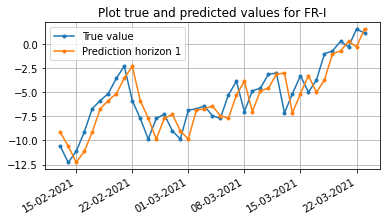

In [18]:
loc = 'BE'
df_predicted = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, return_type='dict_df', geo=dg.loc_init)
df_actual = dg.remove_padded_y(Y_test, idx=test_idx, return_type='dict_df', geo=dg.loc_init)
plot_prediction_vs_actual(df_actual, df_predicted, dg.get_y_dates(test_idx), 'FR-I', horizon=1)

# def plot_prediction_vs_actual(df_y_real, df_y_predicted, prediction_dates, cur_loc, horizon=1, mode=0):

### Dense model

In [19]:
batch_size = len(X_train)
batch_input_shape = (batch_size, n_samples, n_features)
dense_model_train = get_dense_model(batch_input_shape)
print(dense_model_train.output_shape)
dense_model_train.summary()
start = time.time()
dense_model_train.fit(X_train, Y_train, epochs=400, verbose=1, batch_size=batch_size)
end = time.time() - start
print(f"computed in {str(str(timedelta(seconds=end)))} s")

(61576, 20)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (61576, 30)               0         
_________________________________________________________________
dense_7 (Dense)              (61576, 20)               620       
Total params: 620
Trainable params: 620
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 [==============================] - 0s 151ms/step - loss: 0.3921 - mse: 0.3921 - mae: 0.5040 - root_mean_squared_error: 0.6262
Epoch 2/400
1/1 [==============================] - 0s 7ms/step - loss: 0.3566 - mse: 0.3566 - mae: 0.4770 - root_mean_squared_error: 0.5972
Epoch 3/400
1/1 [==============================] - 0s 10ms/step - loss: 0.3333 - mse: 0.3333 - mae: 0.4587 - root_mean_squared_error: 0.5773
Epoch 4/400
1/1 [==============================] - 0s 5ms/step - loss: 0.3151 - mse

1/1 [==============================] - 0s 5ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1365 - root_mean_squared_error: 0.2058
Epoch 113/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0420 - mse: 0.0420 - mae: 0.1359 - root_mean_squared_error: 0.2050
Epoch 114/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1353 - root_mean_squared_error: 0.2042
Epoch 115/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0414 - mse: 0.0414 - mae: 0.1347 - root_mean_squared_error: 0.2034
Epoch 116/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1342 - root_mean_squared_error: 0.2026
Epoch 117/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1336 - root_mean_squared_error: 0.2019
Epoch 118/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1330 - root_mean_squared_error: 0.2011
Epoch 119/400
1/1 [=

1/1 [==============================] - 0s 5ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.1077 - root_mean_squared_error: 0.1609
Epoch 227/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1079 - root_mean_squared_error: 0.1607
Epoch 228/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1076 - root_mean_squared_error: 0.1606
Epoch 229/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1078 - root_mean_squared_error: 0.1605
Epoch 230/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1074 - root_mean_squared_error: 0.1604
Epoch 231/400
1/1 [==============================] - 0s 7ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1077 - root_mean_squared_error: 0.1603
Epoch 232/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1073 - root_mean_squared_error: 0.1601
Epoch 233/400
1/1 [=

1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1023 - root_mean_squared_error: 0.1525
Epoch 341/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1026 - root_mean_squared_error: 0.1524
Epoch 342/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1022 - root_mean_squared_error: 0.1524
Epoch 343/400
1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1025 - root_mean_squared_error: 0.1523
Epoch 344/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1022 - root_mean_squared_error: 0.1523
Epoch 345/400
1/1 [==============================] - 0s 10ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1025 - root_mean_squared_error: 0.1523
Epoch 346/400
1/1 [==============================] - 0s 6ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1021 - root_mean_squared_error: 0.1522
Epoch 347/400
1/1 [

In [20]:
batch_size = len(X_test)
dense_model_pred = get_dense_model(batch_input_shape=(batch_size, n_samples, n_features) )
dense_model_pred.set_weights(dense_model_train.get_weights())

Y_pred = np.squeeze(dense_model_pred.predict(X_test, batch_size=batch_size))
Y_pred_unscaled = dg.inverse_transform_y(Y_pred, idx=test_idx, geo=dg.loc_init)
Y_pred_real = dg.remove_padded_y(Y_pred_unscaled, idx=test_idx, geo=dg.loc_init)

compute_error(Y_pred_real, Y_test_real)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
0,4.183613,37.64569,5.518753,67.801497,6.902325,100.78906,6.93938,110.519651,7.441996,125.528128,...,9.955083,260.233671,10.418484,282.095582,10.592799,306.915463,10.677025,304.047939,11.250903,325.497256


# Walk forward analysis
Several windows are generated and the error is computed over time on each of those windows
At each iteration, the previous test set is added to the new training set and another test set is created

Exemple:
1.  - train:  [0, 1, 2, 3, 4, 5]
    - test: [6, 7]
2.  - train:  [0, 1, 2, 3, 4, 5, 6, 7]
    - test: [8, 9]

and so on

In [12]:
class ValidationLogger(ProgbarLogger):
    """
    compute metrics on the validation set, using a different batch size than the training set
    at the end of each epoch, the weights of the training model are used to set the validation model
    the error is computed based on the unscaled and unpadded values
    """
    
    def __init__(self, validation_model, val_batch_size, X_val, Y_val, val_idx, val_geo):
        """
        :param validation_model: validation model ready to be used
        :param X_val: X validation set
        :param Y_val: Y validation set, already unscaled and unpadded
        :param val_idx: validation idx
        :param val_geo: validation geoloc
        """
        super(ValidationLogger, self).__init__(count_mode='steps')
        self.validation_model = validation_model
        self.val_batch_size = val_batch_size
        self.X_val = X_val
        self.Y_val = Y_val
        self.val_idx = val_idx
        self.val_geo = val_geo
    
    def on_epoch_end(self, epoch, logs=None):
        """
        at the end of each epoch, compute the metrics asked on the validation set
        """
        self.validation_model.set_weights(self.model.get_weights())
        Y_pred = self.validation_model.predict(self.X_val, batch_size=self.val_batch_size)
        Y_pred = dg.inverse_transform_y(Y_pred, geo=self.val_geo, idx=self.val_idx)
        Y_pred = dg.remove_padded_y(Y_pred, geo=self.val_geo, idx=self.val_idx)
        for metric in validation_metrics:
            metric.reset_states()
            metric.update_state(Y_pred, self.Y_val)
            logs[f"val_{metric.name}"] = metric.result().numpy()  # prepend name for validation set
        super(ValidationLogger, self).on_epoch_end(epoch, logs)
        


In [13]:
def walk_forward_evaluation_untrainable(model_generator: callable, nb_fit_first: int, nb_validation: int, 
                                        nb_test: int, verbose: int = 1, *args, **kwargs) -> pd.DataFrame:
    """
    walk forward evaluation for a model that must not be trained (such as the repeat last model)
    """
    # initial index used
    max_len = dg.batch_size
    train_idx = np.arange(nb_fit_first)
    valid_idx = np.arange(nb_fit_first, nb_fit_first + nb_validation)  # validation set is simply ignored
    if nb_fit_first + nb_validation >= max_len:
        finished = True  # no test can be done
    else:
        finished = False  # a test set can be created
        test_idx = np.arange(nb_fit_first + nb_validation, min(nb_fit_first + nb_validation + nb_test, max_len))
    df_error = pd.DataFrame()
    walk = 0
    last_iter = False  # True when the last iteration is reached
    while not finished:
        X_train = dg.get_x(train_idx)  # set the scalers
        Y_train = dg.get_y(train_idx)
        X_test = dg.get_x(test_idx, geo=dg.loc_init, use_previous_scaler=True)
        Y_test_real = dg.get_y(test_idx, geo=dg.loc_init, scaled=False)
        Y_test_real = dg.remove_padded_y(Y_test_real, geo=dg.loc_init, idx=test_idx)
        
        batch_size = len(X_test)
        model_pred = model_generator(batch_input_shape=(batch_size, n_samples, n_features))
        Y_predicted = model_pred.predict(X_test, batch_size=batch_size)
        Y_predicted_real = dg.inverse_transform_y(Y_predicted, geo=dg.loc_init, idx=test_idx)
        Y_predicted_real = dg.remove_padded_y(Y_predicted_real, geo=dg.loc_init, idx=test_idx)
        
        
        # compute the error using the unpadded and unscaled data
        error = compute_error(Y_test_real, Y_predicted_real)
        name = f'walk {walk + 1}'
        error['walk'] = name
        error['nb_test_datapoints'] = len(Y_test_real)
        error['days_train'] = len(train_idx)
        error['days_valid'] = len(valid_idx)
        error['days_test'] = len(test_idx)
        error = error.set_index('walk')
        df_error = df_error.append(error)

        if verbose != 0:
            display(df_error)
        if last_iter:
            finished = True
        # indexes for next fit
        train_idx = np.arange(train_idx[-1] + 1 + nb_test)
        valid_idx += nb_test
        if test_idx[-1] + nb_test >= max_len:  # last iteration, less points can be used for the test set
            last_iter = True  # last iteration to be done
            test_idx = np.arange(test_idx[-1], max_len)
        else:
            test_idx += nb_test
        walk += 1
    df_error.loc['mean'] = df_error.mean()
    if verbose != 0:
        display(df_error)
    return df_error


def walk_forward_evaluation(model_generator: callable, nb_fit_first: int, nb_validation: int, nb_test: int, 
                            epochs: int = 400, plot=False, verbose: int = 1,
                            return_history: bool = False, batch_size_fun: callable = None,
                            es_stop_val: bool = False, patience : int = 25, *args, **kwargs
                           ) -> Union[pd.DataFrame, List[History]]:
    """
    evaluates a model using a walk forward evaluation: multiples fit are done, each followed by at most nb_test
    to evaluate the model
    :param model_generator: function returning the model to evaluate
    :param nb_fit_first: number of datapoints used for the first fit
    :param nb_validation: number of datapoints used for each evaluation set
    :param nb_test: number of datapoints used for the test set (at most)
    :param epochs: number of epochs used on each fit
    :param verbose: verbose level. Passed to fit and used to display the error dataframe
    :param return_history: if True, returns the list of history of each walk
    :param batch_size_fun: function used to compute the batch size based on the X_train tensor
        if not specified, default to batch_size = len(train_idx)
    :param es_stop_val: whether to do an early stop based on the validation set or not
    :param patience: patience to use when using an early stop
    """
    # initial index used
    max_len = dg.batch_size
    train_idx = np.arange(nb_fit_first)
    valid_idx = np.arange(nb_fit_first, nb_fit_first + nb_validation)
    if nb_fit_first + nb_validation >= max_len:
        finished = True  # no test can be done
    else:
        finished = False  # a test set can be created
        test_idx = np.arange(nb_fit_first + nb_validation, min(nb_fit_first + nb_validation + nb_test, max_len))
    df_error = pd.DataFrame()
    walk = 0
    last_iter = False  # True when the last iteration is reached
    all_history = []
    
    while not finished:
        X_train = dg.get_x(train_idx)
        Y_train = dg.get_y(train_idx)
        if batch_size_fun is None:
            batch_size = len(X_train)
        else:
            batch_size = batch_size_fun(X_train)
            
        if len(valid_idx) > 0:
            X_val = dg.get_x(valid_idx, geo=dg.loc_init, use_previous_scaler=True)
            Y_val_real = dg.get_y(valid_idx, geo=dg.loc_init, scaled=False)
            Y_val_real = dg.remove_padded_y(Y_val_real, geo=dg.loc_init, idx=valid_idx)
            batch_size_val = len(X_val)
            model_validation = model_generator(batch_input_shape=(batch_size_val, n_samples, n_features))
            val_log = ValidationLogger(model_validation, len(X_val), X_val, Y_val_real, valid_idx, dg.loc_init)
            if es_stop_val:
                callbacks = [val_log, EarlyStopping(monitor="val_root_mean_squared_error", patience=patience)]
            else:
                callbacks = [val_log]
        else:
            callbacks = None
            
        model_train = model_generator(batch_input_shape=(batch_size, n_samples, n_features))

        history = model_train.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)
        
        # test only on the unaugmented data without padding
        batch_size = len(test_idx)
        # construct a new model and use the previous weights to set it
        model_pred = model_generator(batch_input_shape=(batch_size, n_samples, n_features))
        model_pred.set_weights(model_train.get_weights())
        X_test = dg.get_x(test_idx, geo=dg.loc_init, use_previous_scaler=True)
        Y_test = dg.get_y(test_idx, geo=dg.loc_init, use_previous_scaler=True)
        Y_test_real = dg.get_y(test_idx, geo=dg.loc_init, scaled=False)
        Y_test_real = dg.remove_padded_y(Y_test_real, geo=dg.loc_init, idx=test_idx)
        Y_predicted = model_pred.predict(X_test, batch_size=batch_size)
        Y_predicted_real = dg.inverse_transform_y(Y_predicted, geo=dg.loc_init, idx=test_idx)
        Y_predicted_real = dg.remove_padded_y(Y_predicted_real, geo=dg.loc_init, idx=test_idx)        
        if return_history:
            # add test metrics to the history for this walk, based on the unpadded unscaled data 
            # except for the loss
            for metric in model_train.metrics:
                metric.reset_states()
                if metric.name == 'loss':
                    metric.update_state(Y_predicted_real, Y_test_real)
                else:
                    # compute metric accross each horizon
                    for i in range(n_forecast):
                        metric.update_state(Y_predicted_real[:, i], Y_test_real[:, i])
                        history.history[f"test_{metric.name}(t+{i+1})"] = [metric.result().numpy()]
                        metric.reset_states()
                    # compute mean of metric on all horizon
                    metric.update_state(Y_predicted_real, Y_test_real)
                # prepend name for test set
                history.history[f"test_{metric.name}"] = [metric.result().numpy()]
            # add number of unpadded datapoints
            history.history['nb_test_datapoints'] = [len(Y_test_real)]
            all_history.append(history)
        if not return_history or verbose != 0:
            # compute the error using the unpadded and unscaled data
            error = compute_error(Y_test_real, Y_predicted_real)
            name = f'walk {walk + 1}'
            error['walk'] = name
            error['nb_test_datapoints'] = len(Y_test_real)
            error['days_train'] = len(train_idx)
            error['days_valid'] = len(valid_idx)
            error['days_test'] = len(test_idx)
            error['epochs'] = len(history.history['loss'])
            error = error.set_index('walk')
            df_error = df_error.append(error)
        if verbose != 0:
            display(df_error)
        if last_iter:
            finished = True
        # indexes for next fit
        train_idx = np.arange(train_idx[-1] + 1 + nb_test)
        valid_idx += nb_test
        if test_idx[-1] + nb_test >= max_len:  # last iteration, less points can be used for the test set
            last_iter = True  # last iteration to be done
            test_idx = np.arange(test_idx[-1], max_len)
        else:
            test_idx += nb_test
        walk += 1
    if not return_history or verbose != 0:
        df_error.loc['mean'] = df_error.mean()
        if verbose != 0:
            display(df_error)
        
    return df_error if not return_history else all_history

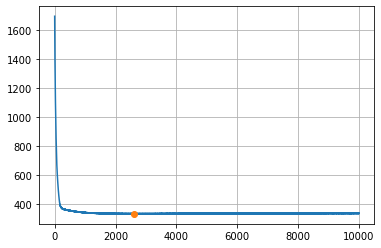

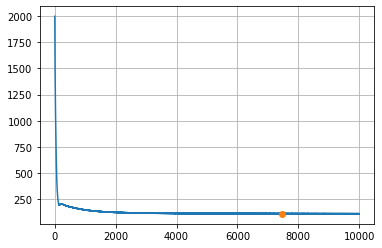

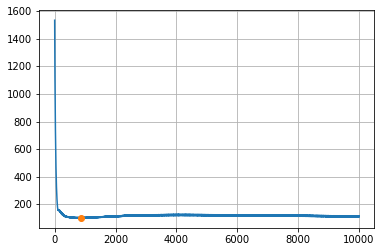

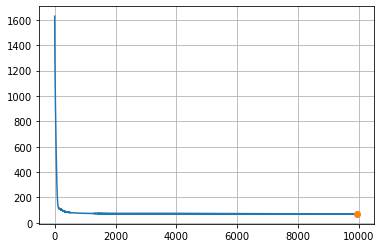

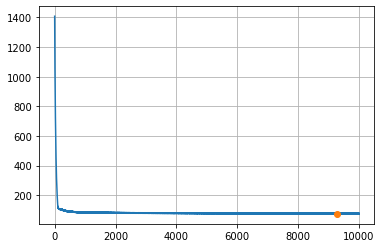

In [31]:
list_history_dense = walk_forward_evaluation(get_dense_model, 230, 30, 30, epochs=10000, verbose=0, 
                                       es_stop_val=False, patience=250, return_history=True)

patience = 200
for i in range(len(list_history_dense)):
    val_metric = list_history_dense[i].history['val_mean_absolute_error']
    best_found = np.inf
    best_found_idx = -1
    count = 0
    for j in range(len(val_metric)):  # tries to find the minimum of val_mae
        if val_metric[j] <= best_found:
            best_found = val_metric[j]
            best_found_idx = j
            count = 0
        else:
            count += 1
            if count == patience:
                break
    plt.figure()
    plt.plot(val_metric)
    plt.plot(best_found_idx, best_found, 'o')
    plt.grid()
    plt.show()

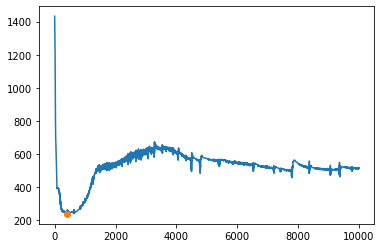

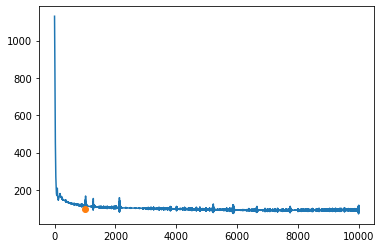

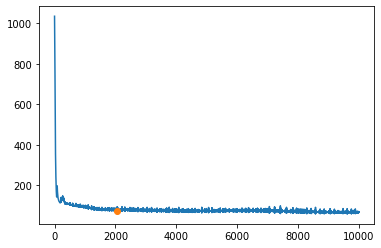

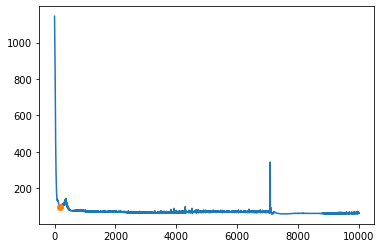

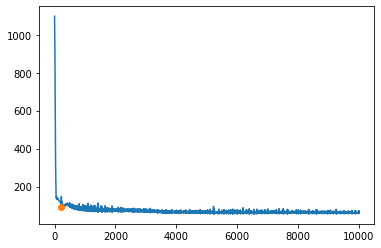

In [21]:
list_history_simple = walk_forward_evaluation(get_simple_autoencoder, 230, 30, 30, epochs=10000, verbose=0, 
                                       es_stop_val=False, patience=200, return_history=True)

patience = 200
for i in range(len(list_history_simple)):
    val_metric = list_history_simple[i].history['val_mean_absolute_error']
    best_found = np.inf
    best_found_idx = -1
    count = 0
    for j in range(len(val_metric)):  # tries to find the minimum of val_mae
        if val_metric[j] <= best_found:
            best_found = val_metric[j]
            best_found_idx = j
            count = 0
        else:
            count += 1
            if count == patience:
                break
    plt.figure()
    plt.plot(val_metric)
    plt.plot(best_found_idx, best_found, 'o')
    plt.show()

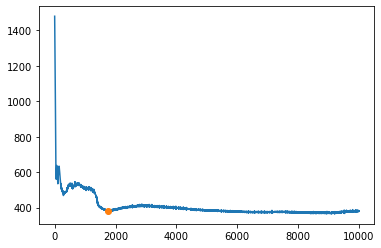

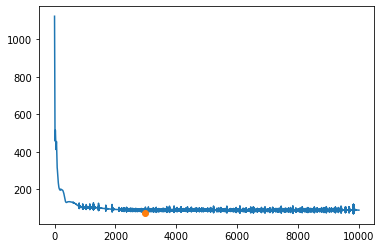

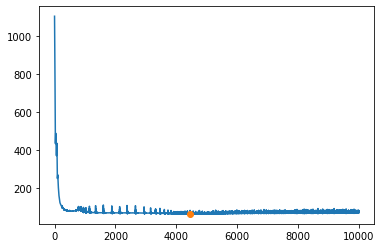

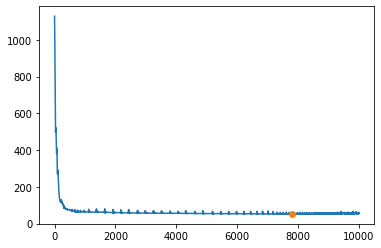

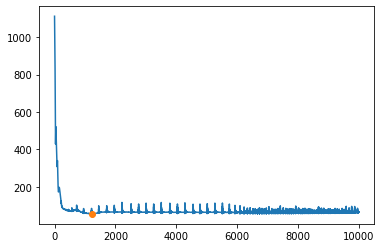

In [29]:
list_history = walk_forward_evaluation(get_encoder_decoder, 230, 30, 30, epochs=10000, verbose=1, 
                                       es_stop_val=False, return_history=True)

patience = 1100
for i in range(len(list_history)):
    val_metric = list_history[i].history['val_mean_absolute_error']
    best_found = np.inf
    best_found_idx = -1
    count = 0
    for j in range(len(val_metric)):  # tries to find the minimum of val_mae
        if val_metric[j] <= best_found:
            best_found = val_metric[j]
            best_found_idx = j
            count = 0
        else:
            count += 1
            if count == patience:
                break
    plt.figure()
    plt.plot(val_metric)
    plt.plot(best_found_idx, best_found, 'o')
    plt.show()

In [19]:
 walk_forward_evaluation_untrainable(get_baseline, 230, 30, 30, verbose=0)

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
walk,,,,,,,,,,,,,,,,,,,,,
walk 1,561.547367,1.037205e+06,577.891881,1.082053e+06,593.580700,1.126843e+06,608.588154,1.171340e+06,622.847988,1.215259e+06,...,740.683599,1.673787e+06,745.841777,1.698870e+06,750.777180,1.722817e+06,690.0,230.0,30.0,30.0
walk 2,7.972295,1.186103e+02,14.404034,4.069617e+02,20.986539,8.755714e+02,27.499822,1.517426e+03,33.966309,2.331104e+03,...,115.886719,2.726877e+04,122.193231,3.018695e+04,128.221554,3.310810e+04,690.0,260.0,30.0,30.0
walk 3,10.362622,2.305871e+02,19.092851,7.399994e+02,27.493887,1.539609e+03,35.536951,2.580633e+03,43.176288,3.819086e+03,...,115.569247,2.269704e+04,119.501753,2.374068e+04,123.139227,2.474908e+04,690.0,290.0,30.0,30.0
walk 4,11.059496,3.588601e+02,18.242590,8.855247e+02,25.567225,1.805116e+03,33.015534,3.165562e+03,40.623195,5.033598e+03,...,149.231835,8.869694e+04,158.084351,1.001841e+05,166.897494,1.123516e+05,690.0,320.0,30.0,30.0
walk 5,12.225772,6.050853e+02,25.107330,2.605471e+03,38.720680,6.090567e+03,52.569547,1.116085e+04,66.672031,1.781318e+04,...,225.758257,1.766667e+05,234.885587,1.889199e+05,242.584344,1.998684e+05,92.0,350.0,30.0,4.0
mean,120.633510,2.077036e+05,130.947737,2.173382e+05,141.269806,2.274308e+05,151.442001,2.379530e+05,161.457162,2.488513e+05,...,269.425932,3.978233e+05,276.101340,4.083803e+05,282.323960,4.185788e+05,570.4,290.0,30.0,24.8


# Optimisation of hyperparameters

In [16]:
hyper_parameter = {
    'hidden_1': [4, 8, 16],
    'hidden_2': [0, 4, 8, 16],
    'lr': [0.001, 0.01],
    'activation': ['relu', 'elu'],
    'reg': [lambda x: regularizers.l1(l=x), lambda x: None],
    'regw': [5e-4, 1e-3],
    'optimizer': ['Adam', 'RMSprop'],
    'losses': ['mse', 'mae', custom_loss_function],
    'scaling': [MinMaxScaler, StandardScaler],
    'batch_size_div': [1],
    'epochs': [1500],
    'patience': [200]
}

def get_encoder_decoder(batch_input_shape, p):
    model = Sequential()
    model.add(LSTM(p['hidden_1'], return_sequences=(p['hidden_2'] != 0), 
                   batch_input_shape=batch_input_shape, kernel_regularizer=p['reg'](p['regw'])))
    if p['hidden_2'] != 0:
        model.add(LSTM(p['hidden_2'], return_sequences=False, kernel_regularizer=p['reg'](p['regw'])))
    model.add(RepeatVector(n_forecast))  # repeat
    if p['hidden_2'] != 0:
        model.add(LSTM(p['hidden_2'], return_sequences=True, kernel_regularizer=p['reg'](p['regw'])))  # dec
    if not predict_one:
        model.add(LSTM(p['hidden_1'], return_sequences=True, kernel_regularizer=p['reg'](p['regw'])))  # dec
        model.add(TimeDistributed(Dense(1, kernel_regularizer=p['reg'](p['regw']), activation=p['activation'])))
        model.add(Reshape((n_forecast,)))
    else:
        model.add(LSTM(p['hidden_1'], return_sequences=False, kernel_regularizer=p['reg'](p['regw'])))  # dec
        model.add(Dense(1, kernel_regularizer=p['reg'](p['regw']), activation=p['activation']))
        model.add(Reshape((1,)))
    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    K.set_value(model.optimizer.learning_rate, p['lr'])
    return model
    

def talos_walk(x_train, y_train, x_val, y_val, p):
    """
    walk forward evaluation used by talos to determine the best model to keep
    """
    dg.set_scaler(p['scaling'])
    model_generator = lambda batch_input_shape: get_encoder_decoder(batch_input_shape, p)

    batch_size_fun = lambda x : int(x.shape[0] / p['batch_size_div'])
    history_list = walk_forward_evaluation(model_generator, nb_fit_first=230, nb_validation=30, nb_test=30, 
                                      epochs=p['epochs'], plot=False, verbose=0, patience = p['patience'],
                                      batch_size_fun=batch_size_fun, return_history=True, es_stop_val=True)
    # compute history to return, based on the list of history
    history = History()
    # used to trick talos to compute the right amount of round_epochs. needs to be the first entry of the dict
    # create an array of len == mean of number of epoch of each history
    history.history['ep'] = np.arange(int(np.mean([len(hist.history['loss']) for hist in history_list]))) + 1
    for log in history_list[0].history.keys():
        history.history[log] = [np.mean([hist.history[log][-1] for hist in history_list])]
    return history, model_generator((1, n_samples, n_features))

scan_object = talos.Scan(
    x=[],
    y=[],
    x_val=[],
    y_val=[],
    params=hyper_parameter,
    model=talos_walk,
    experiment_name='trends1', 
    fraction_limit=0.01
)

  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("RMSE", analyze_object.low('root_mean_squared_error'))
print("TEST MAE", analyze_object.low('test_mae'))
print("TEST MSE", analyze_object.low('test_mse'))
print("TEST RMSE", analyze_object.low('test_root_mean_squared_error'))
df = analyze_object.table('test_mae(t+20)', ascending=True)
print(df.columns)
columns = [f"test_mae(t+{i})" for i in range(1, n_forecast+1)]
df[['hidden_1', 'hidden_2', 'lr', 'batch_size_div', 'scaling', 'test_mse', 'test_mae'] + columns]

In [ ]:
df.loc[0][hyper_parameter.keys()]

# 2 estimators combined
The first estimator should be simple and output an estimate $ \hat{y}_{(1)}(t) $ of $ y(t) $
The correction factor ($ C(t) $) between the estimation and the real value is then computed:

$$ y(t) = \hat{y}_{(1)}(t) * ( 1 + C(t)) $$

$$ C(t) = \frac{y(t) - \hat{y}_{(1)}(t)}{\hat{y}_{(1)}(t)} $$

This formula is used such that $C(t)$ should be bounded in [-1, 1] if the target is a positive value and the first estimator is relatively closed to the expected value.

Anoter estimator is then trained based on the first one. The goal is to be able to predict the correction $ C(t) $ that should be done on the first estimator, in order to reduce the estimation error and get a better prediction. The prediction of $ C(t) $ is written $ \hat{C}(t) $. Once this estimator is computed, the final prediction can be constructed:

$$ \hat{y}(t) = \hat{y}_{(1)}(t) * ( 1 + \hat{C}(t)) $$



## First estimator
Construct the predition $\hat{y}_{(1)}(t)$ and compute $C(t)$ based on it

In [20]:
# X% for training, remaining for test
ratio_training = 0.8
epochs = 200

nb_datapoints = dg.batch_size
max_train = int(ratio_training * nb_datapoints)
train_idx = np.array(range(max_train))
valid_idx = np.array([])
test_idx = np.array(range(max_train, nb_datapoints))

X_train_1 = dg.get_x(train_idx, scaled=True)
Y_train = dg.get_y(train_idx, scaled=True)

if len(valid_idx) > 0:
    X_val_1 = dg.get_x(val_idx, geo=dg.loc_init, scaled=True, use_previous_scaler=True)
    Y_val_unscaled = dg.get_y(val_idx, geo=dg.loc_init, scaled=False)
    Y_val_real = dg.remove_padded_y(Y_val_unscaled, idx=val_idx, geo=dg.loc_init)

X_test_1 = dg.get_x(test_idx, scaled=True, geo=dg.loc_init, use_previous_scaler=True)
Y_test_unscaled = dg.get_y(test_idx, scaled=False, geo=dg.loc_init)
Y_test_real = dg.remove_padded_y(Y_test_unscaled, idx=test_idx, geo=dg.loc_init)
    
"""
X_train_val = dg.get_x(train_val_idx, scaled=True)
df_Y_real = {loc: dg.df[loc][dg.target_columns].iloc[train_val_idx] for loc in dg.df}
Y_real_train_val = dg.get_y(train_val_idx, scaled=True, use_previous_scaler=True)
"""

model_generator = get_dense_model

batch_size_train = len(X_train_1)
batch_size_test = len(X_test_1)

if len(valid_idx) > 0:  # use validation set for an early stop
    batch_size_val = len(X_val_1)
    model_validation = model_generator(batch_input_shape=(batch_size_val, n_samples, dg.n_features))
    val_log = ValidationLogger(model_validation, len(X_val), X_val, Y_val_real, valid_idx, dg.loc_init)
    callbacks = [val_log, EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=20)]
else:
    callbacks = None

model = model_generator(batch_input_shape=(batch_size_train, n_samples, dg.n_features))
history = model.fit(X_train_1, Y_train, batch_size=batch_size_train, epochs=epochs, callbacks=callbacks)
# compute the predictions on both the training and the validation
Y_train_pred_1 = model.predict(X_train_1, batch_size=batch_size_train)

model_prediction = model_generator(batch_input_shape=(batch_size_test, n_samples, dg.n_features))
model_prediction.set_weights(model.get_weights())
Y_test_pred_1 = model_prediction.predict(X_test_1, batch_size=batch_size_test)
# unscale and unpad the data
Y_test_pred_unscaled_1 = dg.inverse_transform_y(Y_test_pred_1, idx=test_idx, geo=dg.loc_init)
Y_test_pred_real_1 = dg.remove_padded_y(Y_test_pred_unscaled_1, idx=test_idx, geo=dg.loc_init)

"""
df_predicted_1 = dg.inverse_transform_y(Y_train_val_pred, idx=train_val_idx, return_type='dict_df')
df_predicted_1

# predictions on the training set
model_prediction = model_generator(batch_input_shape=(batch_size_train, n_samples, dg.n_features))
model_prediction.set_weights(model.get_weights())
Y_train_pred = model_prediction.predict(X_train, batch_size=batch_size_train)

# predictions on the validation without augmented regions
model_prediction = model_generator(batch_input_shape=(batch_size_val, n_samples, dg.n_features))
model_prediction.set_weights(model.get_weights())
Y_val_pred = model_prediction.predict(X_val, batch_size=batch_size_val)
df_Y_real = {loc: dg.df[loc][dg.target_columns].iloc[train_val_idx] for loc in dg.df}
"""

Epoch 1/200
1/1 [==============================] - 1s 610ms/step - loss: 0.5932 - mse: 0.5932 - mae: 0.5063 - root_mean_squared_error: 0.7702
Epoch 2/200
1/1 [==============================] - 0s 6ms/step - loss: 0.5449 - mse: 0.5449 - mae: 0.4782 - root_mean_squared_error: 0.7382
Epoch 3/200
1/1 [==============================] - 0s 5ms/step - loss: 0.5132 - mse: 0.5132 - mae: 0.4598 - root_mean_squared_error: 0.7164
Epoch 4/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4884 - mse: 0.4884 - mae: 0.4455 - root_mean_squared_error: 0.6988
Epoch 5/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4675 - mse: 0.4675 - mae: 0.4335 - root_mean_squared_error: 0.6837
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 0.4491 - mse: 0.4491 - mae: 0.4230 - root_mean_squared_error: 0.6702
Epoch 7/200
1/1 [==============================] - 0s 5ms/step - loss: 0.4327 - mse: 0.4327 - mae: 0.4135 - root_mean_squared_error: 0.6578
Epoch 8/200
1/1 [=

1/1 [==============================] - 0s 5ms/step - loss: 0.1041 - mse: 0.1041 - mae: 0.1917 - root_mean_squared_error: 0.3227
Epoch 60/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1016 - mse: 0.1016 - mae: 0.1895 - root_mean_squared_error: 0.3187
Epoch 61/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0992 - mse: 0.0992 - mae: 0.1874 - root_mean_squared_error: 0.3149
Epoch 62/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0968 - mse: 0.0968 - mae: 0.1853 - root_mean_squared_error: 0.3111
Epoch 63/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0945 - mse: 0.0945 - mae: 0.1833 - root_mean_squared_error: 0.3074
Epoch 64/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0923 - mse: 0.0923 - mae: 0.1815 - root_mean_squared_error: 0.3038
Epoch 65/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0902 - mse: 0.0902 - mae: 0.1796 - root_mean_squared_error: 0.3003
Epoch 66/200
1/1 [========

1/1 [==============================] - 0s 5ms/step - loss: 0.0375 - mse: 0.0375 - mae: 0.1255 - root_mean_squared_error: 0.1936
Epoch 118/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0371 - mse: 0.0371 - mae: 0.1254 - root_mean_squared_error: 0.1926
Epoch 119/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0367 - mse: 0.0367 - mae: 0.1245 - root_mean_squared_error: 0.1916
Epoch 120/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0364 - mse: 0.0364 - mae: 0.1245 - root_mean_squared_error: 0.1907
Epoch 121/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0360 - mse: 0.0360 - mae: 0.1235 - root_mean_squared_error: 0.1898
Epoch 122/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1237 - root_mean_squared_error: 0.1889
Epoch 123/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0354 - mse: 0.0354 - mae: 0.1225 - root_mean_squared_error: 0.1880
Epoch 124/200
1/1 [=

1/1 [==============================] - 0s 5ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.1067 - root_mean_squared_error: 0.1548
Epoch 175/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1058 - root_mean_squared_error: 0.1543
Epoch 176/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1062 - root_mean_squared_error: 0.1538
Epoch 177/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.1053 - root_mean_squared_error: 0.1534
Epoch 178/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1057 - root_mean_squared_error: 0.1529
Epoch 179/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.1048 - root_mean_squared_error: 0.1524
Epoch 180/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1052 - root_mean_squared_error: 0.1520
Epoch 181/200
1/1 [=

"\ndf_predicted_1 = dg.inverse_transform_y(Y_train_val_pred, idx=train_val_idx, return_type='dict_df')\ndf_predicted_1\n\n# predictions on the training set\nmodel_prediction = model_generator(batch_input_shape=(batch_size_train, n_samples, dg.n_features))\nmodel_prediction.set_weights(model.get_weights())\nY_train_pred = model_prediction.predict(X_train, batch_size=batch_size_train)\n\n# predictions on the validation without augmented regions\nmodel_prediction = model_generator(batch_input_shape=(batch_size_val, n_samples, dg.n_features))\nmodel_prediction.set_weights(model.get_weights())\nY_val_pred = model_prediction.predict(X_val, batch_size=batch_size_val)\ndf_Y_real = {loc: dg.df[loc][dg.target_columns].iloc[train_val_idx] for loc in dg.df}\n"

In [21]:
# compute the corrections and add them to a dataframe
data_dg_2 = [f'{topic}(t{i})' for i in range(-n_samples+1, 0, 1) for topic in list_topics] + [topic for topic in list_topics]
target_df_2 = [f'{target}(t+{i})' for i in range(1, n_forecast+1)]
df_c = {loc : dg.df[loc][data_dg_2 + target_df_2] for loc in dg.df}
"""
for k in dg.df:
    # add the data columns to the dataframe
    df_c[k] = dg.df[k][data_dg_2]
    for t in range(1, n_forecast+1):  # add the target columns
        target_t = f'{target}(t+{t})'
        df_c[k][f'C(t+{t})'] = (df_Y_real[k][target_t] - df_predicted_1[k][target_t]) / df_predicted_1[k][target_t]
"""

"\nfor k in dg.df:\n    # add the data columns to the dataframe\n    df_c[k] = dg.df[k][data_dg_2]\n    for t in range(1, n_forecast+1):  # add the target columns\n        target_t = f'{target}(t+{t})'\n        df_c[k][f'C(t+{t})'] = (df_Y_real[k][target_t] - df_predicted_1[k][target_t]) / df_predicted_1[k][target_t]\n"

In [22]:
df_c['BE']

Fièvre(t-29)  Mal de gorge(t-29)  Symptôme(t-29)  \
LOC DATE                                                           
BE  2020-03-04     25.402051           25.829284       22.034428   
    2020-03-05     25.245307           25.878495       21.941446   
    2020-03-06     24.616242           25.042280       21.586268   
    2020-03-07     24.280325           24.475947       21.198360   
    2020-03-08     24.268387           24.651690       20.792376   
...                      ...                 ...             ...   
    2021-03-17     22.274262           35.131666       22.239621   
    2021-03-18     22.250779           35.052849       22.831868   
    2021-03-19     22.082581           34.776027       23.138793   
    2021-03-20     21.799723           33.634505       23.251944   
    2021-03-21     21.560343           32.425871       23.347154   

                Fièvre(t-28)  Mal de gorge(t-28)  Symptôme(t-28)  \
LOC DATE                                                           
BE  2020-03-04     25.245307           25.878495       21.941446   
    2020-03-05     24.616242           25.042280       21.586268   
    2020-03-06     24.280325           24.475947       21.198360   
    2020-03-07     24.268387           24.651690       20.792376   
    2020-03-08     24.279004           24.994527       20.590845   
...                      ...                 ...             ...   
    2021-03-17     22.250779           35.052849       22.831868   
    2021-03-18     22.082581           34.776027       23.138793   
    2021-03-19     21.799723           33.634505       23.251944   
    2021-03-20     21.560343           32.425871       23.347154   
    2021-03-21     21.668993           31.181405       23.458170   

                Fièvre(t-27)  Mal de gorge(t-27)  Symptôme(t-27)  \
LOC DATE                                                           
BE  2020-03-04     24.616242           25.042280       21.586268   
    2020-03-05     24.280325           24.475947       21.198360   
    2020-03-06     24.268387           24.651690       20.792376   
    2020-03-07     24.279004           24.994527       20.590845   
    2020-03-08     24.030306           24.884379       20.461919   
...                      ...                 ...             ...   
    2021-03-17     22.082581           34.776027       23.138793   
    2021-03-18     21.799723           33.634505       23.251944   
    2021-03-19     21.560343           32.425871       23.347154   
    2021-03-20     21.668993           31.181405       23.458170   
    2021-03-21     21.891241           29.244671       23.651876   

                Fièvre(t-26)  ...  TOT_HOSP(t+11)  TOT_HOSP(t+12)  \
LOC DATE                      ...                                   
BE  2020-03-04     24.280325  ...      253.142857      373.142857   
    2020-03-05     24.268387  ...      373.142857      531.428571   
    2020-03-06     24.279004  ...      531.428571      729.142857   
    2020-03-07     24.030306  ...      729.142857      928.857143   
    2020-03-08     24.089472  ...      928.857143     1145.000000   
...                      ...  ...             ...             ...   
    2021-03-17     21.799723  ...     2697.571429     2764.142857   
    2021-03-18     21.560343  ...     2764.142857     2838.857143   
    2021-03-19     21.668993  ...     2838.857143     2887.857143   
    2021-03-20     21.891241  ...     2887.857143     2920.714286   
    2021-03-21     21.963463  ...     2920.714286     2954.285714   

                TOT_HOSP(t+13)  TOT_HOSP(t+14)  TOT_HOSP(t+15)  \
LOC DATE                                                         
BE  2020-03-04      531.428571      729.142857      928.857143   
    2020-03-05      729.142857      928.857143     1145.000000   
    2020-03-06      928.857143     1145.000000     1389.428571   
    2020-03-07     1145.000000     1389.428571     1685.857143   
    2020-03-08     1389.428571     1685.857143     2010.285714   
.

In [23]:
scaler_generator = MinMaxScaler
dg_2 = util.DataGenerator(df_c, n_samples, n_forecast, target=target, scaler_generator=scaler_generator, 
                          scaler_type='batch', augment_merge=0, predict_one=False, cumsum=False,
                          data_columns=[k for k in list_topics], no_lag=True)
dg_2.set_loc_init(dg.loc_init)  # consider the other localisations as being augmented

## Train the second estimator to compute $Y_2(t)$

In [24]:
X_train_2 = dg_2.get_x(train_idx, scaled=True)
Y_train_2 = dg_2.get_y(train_idx, scaled=True)

if len(valid_idx) > 0:
    X_val_2 = dg_2.get_x(valid_idx, scaled=True, use_previous_scaler=True, geo=dg_2.loc_init)
    Y_val_unscaled_2 = dg.get_y(valid_idx, geo=dg.loc_init, scaled=False)
    Y_val_real_2 = dg.remove_padded_y(Y_val_unscaled, idx=val_idx, geo=dg.loc_init)
    batch_size_val = len(X_val_2)
    
X_test_2 = dg_2.get_x(test_idx, scaled=True, use_previous_scaler=True, geo=dg_2.loc_init)
Y_test_unscaled_2 = dg.get_y(test_idx, scaled=False, geo=dg_2.loc_init)
Y_test_real_2 = dg.remove_padded_y(Y_test_unscaled_2, idx=test_idx, geo=dg_2.loc_init)

model_generator = get_dense_model

batch_size_train = len(X_train_2)
batch_size_test = len(X_test_2)
model = model_generator(batch_input_shape=(batch_size_train, n_samples, dg_2.n_features))
    
history = model.fit(X_train_2, Y_train_2, batch_size=batch_size_train, epochs=epochs, callbacks=None)
# compute the predictions on both the training and the validation
Y_train_pred_2 = model.predict(X_train_2, batch_size=batch_size_train)

model_prediction = model_generator(batch_input_shape=(batch_size_test, n_samples, dg_2.n_features))
model_prediction.set_weights(model.get_weights())
Y_test_pred_2 = model_prediction.predict(X_test_2, batch_size=batch_size_test)
# unscale and unpad the data
Y_test_pred_unscaled_2 = dg_2.inverse_transform_y(Y_test_pred_2, idx=test_idx, geo=dg_2.loc_init)
Y_test_pred_real_2 = dg.remove_padded_y(Y_test_pred_unscaled_2, idx=test_idx, geo=dg_2.loc_init)

Epoch 1/200
1/1 [==============================] - 0s 149ms/step - loss: 0.4726 - mse: 0.4726 - mae: 0.5215 - root_mean_squared_error: 0.6874
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 0.4410 - mse: 0.4410 - mae: 0.5016 - root_mean_squared_error: 0.6641
Epoch 3/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4200 - mse: 0.4200 - mae: 0.4883 - root_mean_squared_error: 0.6481
Epoch 4/200
1/1 [==============================] - 0s 7ms/step - loss: 0.4035 - mse: 0.4035 - mae: 0.4779 - root_mean_squared_error: 0.6352
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 0.3896 - mse: 0.3896 - mae: 0.4690 - root_mean_squared_error: 0.6242
Epoch 6/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3774 - mse: 0.3774 - mae: 0.4612 - root_mean_squared_error: 0.6143
Epoch 7/200
1/1 [==============================] - 0s 6ms/step - loss: 0.3664 - mse: 0.3664 - mae: 0.4542 - root_mean_squared_error: 0.6053
Epoch 8/200
1/1 [

1/1 [==============================] - 0s 6ms/step - loss: 0.1423 - mse: 0.1423 - mae: 0.2955 - root_mean_squared_error: 0.3773
Epoch 60/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1404 - mse: 0.1404 - mae: 0.2939 - root_mean_squared_error: 0.3747
Epoch 61/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1385 - mse: 0.1385 - mae: 0.2922 - root_mean_squared_error: 0.3722
Epoch 62/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1367 - mse: 0.1367 - mae: 0.2906 - root_mean_squared_error: 0.3697
Epoch 63/200
1/1 [==============================] - 0s 8ms/step - loss: 0.1349 - mse: 0.1349 - mae: 0.2890 - root_mean_squared_error: 0.3673
Epoch 64/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1332 - mse: 0.1332 - mae: 0.2875 - root_mean_squared_error: 0.3649
Epoch 65/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1315 - mse: 0.1315 - mae: 0.2859 - root_mean_squared_error: 0.3626
Epoch 66/200
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: 0.0869 - mse: 0.0869 - mae: 0.2419 - root_mean_squared_error: 0.2947
Epoch 118/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.2416 - root_mean_squared_error: 0.2943
Epoch 119/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0863 - mse: 0.0863 - mae: 0.2413 - root_mean_squared_error: 0.2938
Epoch 120/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0861 - mse: 0.0861 - mae: 0.2411 - root_mean_squared_error: 0.2934
Epoch 121/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0858 - mse: 0.0858 - mae: 0.2408 - root_mean_squared_error: 0.2930
Epoch 122/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0856 - mse: 0.0856 - mae: 0.2406 - root_mean_squared_error: 0.2926
Epoch 123/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0854 - mse: 0.0854 - mae: 0.2403 - root_mean_squared_error: 0.2922
Epoch 124/200
1/1 [=

1/1 [==============================] - 0s 6ms/step - loss: 0.0782 - mse: 0.0782 - mae: 0.2322 - root_mean_squared_error: 0.2796
Epoch 175/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0781 - mse: 0.0781 - mae: 0.2322 - root_mean_squared_error: 0.2794
Epoch 176/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0780 - mse: 0.0780 - mae: 0.2320 - root_mean_squared_error: 0.2792
Epoch 177/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0779 - mse: 0.0779 - mae: 0.2319 - root_mean_squared_error: 0.2790
Epoch 178/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0778 - mse: 0.0778 - mae: 0.2317 - root_mean_squared_error: 0.2788
Epoch 179/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0777 - mse: 0.0777 - mae: 0.2317 - root_mean_squared_error: 0.2787
Epoch 180/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0776 - mse: 0.0776 - mae: 0.2315 - root_mean_squared_error: 0.2785
Epoch 181/200
1/1 [=

## Construct the final prediction by combining the two

In [25]:
class AssembleLayerTimeDist(tf.keras.Model):
    """
    assemble the prediction from the trends and the predictions from another model
    the same weight is used at every timestep (1 trainable parameter)
    """
    def __init__(self, input_shape):
        super(AssembleLayer, self).__init__(name='')
        self.dense_trends = tf.keras.layers.Dense(1, use_bias=False, 
                                                 kernel_constraint=tf.keras.constraints.MinMaxNorm(0.001, 0.2))
        batch_input_shape = (input_shape[0], input_shape[1], 1)
        self.time_dist = TimeDistributed(self.dense_trends, batch_input_shape=batch_input_shape)

    def call(self, input_tensor, training=False):
        x_trends = input_tensor[:, :, 1:]
        x_hosp = input_tensor[:, :, :1]
        x_trends = tf.keras.layers.Subtract()([x_trends, x_hosp])  # x_trends - x_hosp
        x_trends = self.time_dist(x_trends, training=training)  # apply simple weight
        return tf.keras.layers.Add()([x_trends, x_hosp])  # final prediction = x_hosp + (x_trends - x_hosp) * c

class MinMaxPositive(tf.keras.constraints.Constraint):
    
    def __init__(self, min_value, max_value):
        self.min_max_norm = tf.keras.constraints.MinMaxNorm(min_value, max_value)
        self.non_neg = tf.keras.constraints.NonNeg()
        
    def __call__(self, w):
        return self.min_max_norm(self.non_neg(w))
    
class AssembleLayer(tf.keras.Model):
    """
    assemble the prediction from the trends and the predictions from another model
    different weight are used at every timestep (n_forecast trainable parameter)
    """
    
    def __init__(self, batch_input_shape):
        super(AssembleLayer, self).__init__(name='')
        self.kernel = self.add_weight("kernel", shape=[1,batch_input_shape[1]], 
                                      constraint=MinMaxPositive(0.001, 0.2))

    def call(self, input_tensor, training=False):
        x_trends = input_tensor[:, :, 1]
        x_hosp = input_tensor[:, :, 0]
        x_trends = tf.keras.layers.Subtract()([x_trends, x_hosp])  # x_trends - x_hosp
        x_trends = tf.multiply(x_trends, self.kernel)  # apply simple weight: (x_trends - x_hosp) * c
        return tf.keras.layers.Add()([x_hosp, x_trends])  # final prediction = x_hosp + (x_trends - x_hosp) * c

    
def get_assemble(batch_input_shape):
    model = AssembleLayer(batch_input_shape)
    model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

In [26]:
X_train_assembled = np.stack([Y_train_pred_1, Y_train_pred_2], axis=2)
Y_train_assembled = Y_train  # output the target of the first model
X_test_assembled = np.stack([Y_test_pred_1, Y_test_pred_2], axis=2)
Y_test_assembled_real = Y_test_real

batch_size_train = len(X_train_assembled)
batch_size_test = len(X_test_assembled)

model_generator = get_assemble

model_train = model_generator(batch_input_shape=(batch_size_train, n_forecast, 2))
model_train.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
history = model_train.fit(X_train_assembled, Y_train_assembled, batch_size=batch_size_train, epochs=epochs)
Y_train_assembled_pred = model_train.predict(X_train_assembled, batch_size=batch_size_train)

model_prediction = model_generator(batch_input_shape=(batch_size_test, n_forecast, 2))
model_prediction.set_weights(model_train.get_weights())
Y_test_assembled_pred = model_prediction.predict(X_test_assembled, batch_size=batch_size_test)
# unscale and unpad the data
Y_test_assembled_pred_unscaled = dg_2.inverse_transform_y(Y_test_assembled_pred, idx=test_idx, geo=dg.loc_init)
Y_test_assembled_pred_real = dg.remove_padded_y(Y_test_assembled_pred_unscaled, idx=test_idx, geo=dg.loc_init)

Epoch 1/200
1/1 [==============================] - 0s 187ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1087 - root_mean_squared_error: 0.1514
Epoch 2/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1020 - root_mean_squared_error: 0.1432
Epoch 3/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1020 - root_mean_squared_error: 0.1431
Epoch 4/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1019 - root_mean_squared_error: 0.1431
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1018 - root_mean_squared_error: 0.1430
Epoch 6/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.1018 - root_mean_squared_error: 0.1430
Epoch 7/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.1017 - root_mean_squared_error: 0.1429
Epoch 8/200
1/1 [=

1/1 [==============================] - 0s 4ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1005 - root_mean_squared_error: 0.1419
Epoch 60/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1004 - root_mean_squared_error: 0.1419
Epoch 61/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1004 - root_mean_squared_error: 0.1419
Epoch 62/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1004 - root_mean_squared_error: 0.1419
Epoch 63/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1004 - root_mean_squared_error: 0.1419
Epoch 64/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1004 - root_mean_squared_error: 0.1419
Epoch 65/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.1004 - root_mean_squared_error: 0.1418
Epoch 66/200
1/1 [========

1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1415
Epoch 118/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1415
Epoch 119/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1415
Epoch 120/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1415
Epoch 121/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1415
Epoch 122/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1415
Epoch 123/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1415
Epoch 124/200
1/1 [=

1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1414
Epoch 175/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1414
Epoch 176/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1414
Epoch 177/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1414
Epoch 178/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1414
Epoch 179/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1414
Epoch 180/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.1000 - root_mean_squared_error: 0.1414
Epoch 181/200
1/1 [=

In [27]:
factors = model_prediction.weights[0].numpy().reshape(n_forecast)
for t in range(n_forecast):
    print(f'factor t+{t+1} = {factors[t]:.4f}')

factor t+1 = -0.0000
factor t+2 = -0.0000
factor t+3 = -0.0000
factor t+4 = -0.0000
factor t+5 = -0.0000
factor t+6 = -0.0000
factor t+7 = -0.0000
factor t+8 = -0.0000
factor t+9 = 0.0211
factor t+10 = 0.2000
factor t+11 = -0.0000
factor t+12 = 0.0108
factor t+13 = 0.1821
factor t+14 = 0.1240
factor t+15 = 0.0273
factor t+16 = 0.1335
factor t+17 = 0.1739
factor t+18 = 0.1423
factor t+19 = 0.1470
factor t+20 = 0.1803


In [28]:
error_1 = compute_error(Y_test_pred_real_1, Y_test_real)
error_1['model'] = 'model 1'
error_2 = compute_error(Y_test_pred_real_2, Y_test_real_2)
error_2['model'] = 'model trends'
error_assembled = compute_error(Y_test_assembled_pred_real, Y_test_assembled_real)
error_assembled['model'] = 'assembled'
pd.concat([error_1, error_2, error_assembled]).set_index('model')

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+16),MSE(t+16),MAE(t+17),MSE(t+17),MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20)
model,,,,,,,,,,,,,,,,,,,,,
model 1,46.301735,4519.842861,53.660593,6037.545269,57.017152,6804.437714,92.142339,17386.522419,99.520317,21496.896407,...,192.759223,81760.808359,203.040257,92316.238270,170.655297,67699.264536,176.040426,72553.914441,187.205886,82463.686242
model trends,489.610372,422401.105809,490.480402,425800.190226,472.158875,398935.995617,468.150494,404959.783940,464.351435,381828.321917,...,449.631476,413856.249018,453.291030,422988.612215,459.944266,440231.149542,465.275833,457639.884950,459.667272,448504.637763
assembled,46.301735,4519.842861,53.660593,6037.545269,57.017152,6804.437714,92.142339,17386.522419,99.520317,21496.896407,...,216.905374,101453.374895,233.867003,119913.462140,197.287998,87107.050618,204.577251,95000.988559,221.062858,112156.604992


In [29]:
def walk_forward_assembly(model_generator_1: callable, dg_1: util.DataGenerator,
                          model_generator_2: callable, dg_2: util.DataGenerator,
                          model_generator_as: callable, 
                          nb_fit_first: int, nb_valid: int, nb_test: int, verbose: int = 1,
                          return_history: bool = False, batch_size_fun: callable = None,
                          es_stop_val: bool = False, epochs: int = 200,
                          train_val: bool = False) -> Union[pd.DataFrame, List[History]]:
    """
    evaluates a model using a walk forward evaluation: multiples fit are done, each followed by at most nb_test
    to evaluate the model
    :param model_generator_1: function returning the first model to evaluate
    :param target_1: target for the first model
    :param data_columns_1: data columns for the first model
    :param model_generator_2: function returning the second model to evaluate
    :param target_2: target for the second model
    :param data_columns_2: data columns for the second model
    :param model_generator_as: function returning the assembly model
    :param nb_fit_first: number of datapoints used for the first fit
    :param nb_valid: number of datapoints used for each validation set
    :param nb_test: number of datapoints used for the test set (at most)
    :param epochs: number of epochs used on each fit
    :param verbose: verbose level. Passed to fit and used to display the error dataframe
    :param return_history: if True, returns the list of history of each walk
    :param batch_size_fun: function used to compute the batch size based on the X_train tensor
        if not specified, default to batch_size = len(train_idx)
    :param train_val: if True, the assembler will be trained using the validation set instead of the test set
    """
    # initial index used
    max_len = dg.batch_size
    train_idx = np.arange(nb_fit_first)
    valid_idx = np.arange(nb_fit_first, nb_fit_first + nb_valid)
    if nb_fit_first + nb_valid >= max_len:
        finished = True  # no test can be done
    else:
        finished = False  # a test set can be created
        test_idx = np.arange(nb_fit_first + nb_valid, min(nb_fit_first + nb_valid + nb_test, max_len))
    df_error = pd.DataFrame()
    walk = 0
    last_iter = False  # True when the last iteration is reached
    all_history = []
    
    list_dg = [dg_1, dg_2]
    
    while not finished:
        X_train, Y_train, pred_train = [], [], []
        X_val, Y_val_unscaled, Y_val_real, pred_val = [], [], [], []
        X_test, Y_test_unscaled, Y_test_real = [], [], []
        pred_test, pred_test_unscaled, pred_test_real = [], [], []
        
        # train the two first models
        for i, model_generator in enumerate([model_generator_1, model_generator_2]):
            dg_i = list_dg[i]
            X_train.append(dg_i.get_x(train_idx, scaled=True))
            Y_train.append(dg_i.get_y(train_idx, scaled=True))

            if len(valid_idx) > 0:  # validation set: validation logger and early stop if needed
                X_val.append(dg_i.get_x(valid_idx, geo=dg_i.loc_init, scaled=True, use_previous_scaler=True))
                Y_val_unscaled.append(dg_i.get_y(valid_idx, geo=dg_i.loc_init, scaled=False))
                Y_val_real.append(dg_i.remove_padded_y(Y_val_unscaled[-1], idx=valid_idx, geo=dg_i.loc_init))
                batch_size_val = len(X_val[-1])
                model_validation = model_generator(batch_input_shape=(batch_size_val, n_samples, dg_i.n_features))
                val_log = ValidationLogger(model_validation, batch_size_val, X_val[-1], Y_val_real[-1], 
                                             valid_idx, dg_i.loc_init)
                if es_stop_val:
                    callbacks = [val_log, EarlyStopping(monitor="val_root_mean_squared_error", patience=25)]
                else:
                    callbacks = [val_log]
            else:
                callbacks = None            

            # test set
            X_test.append(dg_i.get_x(test_idx, scaled=True, geo=dg_i.loc_init, use_previous_scaler=True))
            Y_test_unscaled.append(dg_i.get_y(test_idx, scaled=False, geo=dg_i.loc_init))
            Y_test_real.append(dg_i.remove_padded_y(Y_test_unscaled[-1], idx=test_idx, geo=dg_i.loc_init))

            batch_size_train = len(X_train[-1])
            batch_size_test = len(X_test[-1])

            # training of model 1
            model_train = model_generator(batch_input_shape=(batch_size_train, dg_i.n_samples, dg_i.n_features))
            history = model_train.fit(X_train[-1], Y_train[-1], batch_size=batch_size_train, epochs=epochs, 
                                      callbacks=callbacks, verbose=verbose)
            # prediction on the training set
            pred_train.append(model_train.predict(X_train[-1], batch_size=batch_size_train))
            # prediction on the validation set
            if train_val:
                model_validation.set_weights(model_train.get_weights())
                pred_val.append(model_validation.predict(X_val[-1], batch_size=batch_size_val))
            # prediction on the test set
            model_prediction = model_generator(batch_input_shape=(batch_size_test, n_samples, dg_i.n_features))
            model_prediction.set_weights(model_train.get_weights())
            pred_test.append(model_prediction.predict(X_test[-1], batch_size=batch_size_test))
            pred_test_unscaled.append(dg_i.inverse_transform_y(pred_test[-1], idx=test_idx, geo=dg_i.loc_init))
            pred_test_real.append(dg_i.remove_padded_y(pred_test_unscaled[-1], idx=test_idx, geo=dg_i.loc_init))
        
        # train the assembly model
        if train_val:
            X_train_as = np.stack(pred_val, axis=2)
            Y_train_as = Y_val_unscaled[0]  # output the target of the first model
        else:
            X_train_as = np.stack(pred_train, axis=2)
            Y_train_as = Y_train[0]  # output the target of the first model
        X_test_as = np.stack(pred_test, axis=2)
        Y_test_as_real = Y_test_real[0]

        batch_size_train = len(X_train_as)
        batch_size_test = len(X_test_as)
        dg_as = list_dg[0]  # used for inverse scaling and unpadding

        model_train = model_generator_as(batch_input_shape=(batch_size_train, n_forecast, 2))
        model_train.compile(loss=tf.losses.MeanSquaredError(),
                              metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
        history = model_train.fit(X_train_as, Y_train_as, batch_size=batch_size_train, epochs=epochs, 
                                  verbose=verbose)
        pred_train_as = model_train.predict(X_train_as, batch_size=batch_size_train)

        model_prediction = model_generator_as(batch_input_shape=(batch_size_test, n_forecast, 2))
        model_prediction.set_weights(model_train.get_weights())
        pred_test_as = model_prediction.predict(X_test_as, batch_size=batch_size_test)
        # unscale and unpad the data
        pred_test_as_unscaled = dg_as.inverse_transform_y(pred_test_as, idx=test_idx, geo=dg_as.loc_init)
        pred_test_as_real = dg_as.remove_padded_y(pred_test_as_unscaled, idx=test_idx, geo=dg_as.loc_init)
        
        """
        if return_history:
            # add test metrics to the history for this walk, based on the unpadded unscaled data 
            # except for the loss
            for metric in model_train.metrics:
                metric.reset_states()
                if metric.name == 'loss':
                    metric.update_state(Y_predicted_real, Y_test_real)
                else:
                    # compute metric accross each horizon
                    for i in range(n_forecast):
                        metric.update_state(Y_predicted_real[:, i], Y_test_real[:, i])
                        history.history[f"test_{metric.name}(t+{i+1})"] = [metric.result().numpy()]
                        metric.reset_states()
                    # compute mean of metric on all horizon
                    metric.update_state(Y_predicted_real, Y_test_real)
                # prepend name for test set
                history.history[f"test_{metric.name}"] = [metric.result().numpy()]
            # add number of unpadded datapoints
            history.history['nb_test_datapoints'] = [len(Y_test_real)]
            all_history.append(history)
        """
        if not return_history or verbose != 0:
            # compute the error using the unpadded and unscaled data
            for i in range(3):
                if i == 2:  # assembled model
                    error = compute_error(Y_test_as_real, pred_test_as_real)
                    name = f'walk {walk + 1} model assembled'
                    error['nb_test_datapoints'] = len(Y_test_as_real)
                else:  # two first model
                    error = compute_error(Y_test_real[i], pred_test_real[i])
                    name = f'walk {walk + 1} model {i+1}'
                    error['nb_test_datapoints'] = len(Y_test_real[i])
                error['name'] = name
                error['days_train'] = len(train_idx)
                error['days_valid'] = len(valid_idx)
                error['days_test'] = len(test_idx)
                error = error.set_index('name')
                df_error = df_error.append(error)
        
        if verbose != 0:
            display(df_error)
        if last_iter:
            finished = True
        # indexes for next fit
        train_idx = np.arange(train_idx[-1] + 1 + nb_test)
        valid_idx += nb_test
        if test_idx[-1] + nb_test >= max_len:  # last iteration, less points can be used for the test set
            last_iter = True  # last iteration to be done
            test_idx = np.arange(test_idx[-1], max_len)
        else:
            test_idx += nb_test
        walk += 1
    if not return_history:  # compute the mean across all walks
        len_df = len(df_error)
        df_error.loc['mean model 1'] = df_error.iloc[range(0, len_df, 3)].mean()
        df_error.loc['mean model 2'] = df_error.iloc[range(1, len_df, 3)].mean()
        df_error.loc['mean model as'] = df_error.iloc[range(2, len_df, 3)].mean()
    return df_error if not return_history else all_history

In [30]:
dense_all_inputs = lambda batch_input_shape: get_dense_model(batch_input_shape, use_lambda=False)

df_errors_1 = walk_forward_assembly(get_dense_model, dg, dense_all_inputs, dg_2, get_assemble,
                     220, 30, 30, epochs=10, verbose=0)
df_errors_1

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
name,,,,,,,,,,,,,,,,,,,,,
walk 1 model 1,505.729054,6.495597e+05,367.698798,3.314301e+05,287.733333,2.582611e+05,546.258443,8.225574e+05,906.823279,1.867693e+06,...,373.337518,2.849747e+05,305.817006,2.305208e+05,1108.105145,2.481657e+06,690.0,220.0,30.0,30.0
walk 1 model 2,1391.445220,4.391445e+06,1343.777545,4.013385e+06,1345.440652,4.036105e+06,1041.435222,2.408800e+06,1401.400006,4.337240e+06,...,778.828143,1.173737e+06,946.891243,1.822219e+06,874.493834,1.457478e+06,690.0,220.0,30.0,30.0
walk 1 model assembled,505.729054,6.495597e+05,377.837689,3.468586e+05,257.448125,1.704215e+05,543.114882,8.090072e+05,997.831722,2.239625e+06,...,372.727778,2.816934e+05,294.536576,1.809401e+05,1061.104396,2.243174e+06,690.0,220.0,30.0,30.0
walk 2 model 1,291.021760,2.342361e+05,1505.612206,4.349818e+06,171.640618,6.541077e+04,2627.766763,1.369565e+07,218.472706,1.284775e+05,...,143.291524,3.564636e+04,304.719407,1.874394e+05,1927.646953,6.955810e+06,690.0,250.0,30.0,30.0
walk 2 model 2,855.737703,1.607352e+06,782.806488,1.330130e+06,1174.951677,2.590533e+06,877.761759,1.617189e+06,702.588339,1.103183e+06,...,835.200132,1.373516e+06,1347.151070,3.195768e+06,1227.133184,2.679594e+06,690.0,250.0,30.0,30.0
walk 2 model assembled,177.524717,8.842340e+04,1411.958880,3.858575e+06,317.541731,2.045684e+05,2568.513971,1.309135e+07,193.574692,9.313355e+04,...,142.618120,3.480660e+04,304.719407,1.874394e+05,1917.795324,6.880855e+06,690.0,250.0,30.0,30.0
walk 3 model 1,1910.884468,6.667652e+06,824.999120,1.331562e+06,1039.749117,1.980204e+06,2211.926907,9.000141e+06,3560.623825,2.350303e+07,...,309.331914,2.040848e+05,1393.034758,3.561685e+06,1535.475131,4.278128e+06,690.0,280.0,30.0,30.0
walk 3 model 2,926.832844,1.622634e+06,924.541521,1.637535e+06,1006.655671,1.874619e+06,709.833043,1.067497e+06,915.665302,1.603025e+06,...,881.143818,1.556287e+06,1623.210785,4.496581e+06,804.738286,1.347325e+06,690.0,280.0,30.0,30.0
walk 3 model assembled,1896.967443,6.572168e+06,800.686504,1.255881e+06,1037.457259,1.971550e+06,1940.505829,6.981097e+06,3524.381629,2.302833e+07,...,419.878856,3.595604e+05,1393.034758,3.561685e+06,1382.399802,3.531937e+06,690.0,280.0,30.0,30.0


In [47]:
dense_all_inputs = lambda batch_input_shape: get_dense_model(batch_input_shape, use_lambda=False)

df_errors_1 = walk_forward_assembly(get_dense_model, dg, dense_all_inputs, dg_2, get_assemble,
                     220, 30, 30, epochs=1000, verbose=0)
df_errors_1

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
name,,,,,,,,,,,,,,,,,,,,,
walk 1 model 1,204.429573,1.331389e+05,205.129543,1.452423e+05,202.585008,1.270908e+05,197.969829,1.340822e+05,191.819972,1.262198e+05,...,249.734384,125296.996112,256.339936,131194.444790,264.854176,136616.251551,690.0,220.0,30.0,30.0
walk 1 model 2,857.449403,1.495423e+06,847.176601,1.448076e+06,835.923811,1.397476e+06,824.758933,1.346553e+06,811.446414,1.291361e+06,...,674.533051,762345.293831,664.535309,733380.787768,656.679076,710527.486339,690.0,220.0,30.0,30.0
walk 1 model assembled,201.955836,1.322176e+05,205.129543,1.452423e+05,199.594343,1.259375e+05,197.969829,1.340822e+05,191.819972,1.262198e+05,...,249.088411,131389.363513,254.568326,137070.766181,262.835581,142791.064706,690.0,220.0,30.0,30.0
walk 2 model 1,52.007630,6.159798e+03,54.983300,6.696802e+03,68.911206,1.136799e+04,63.867185,8.187963e+03,73.878844,1.051365e+04,...,288.565513,134055.002845,280.916750,124126.537738,295.172741,134822.216432,690.0,250.0,30.0,30.0
walk 2 model 2,670.180804,7.335546e+05,667.310006,7.271113e+05,665.244090,7.209573e+05,664.271445,7.189750e+05,661.604074,7.115761e+05,...,641.832572,661392.908836,639.022650,651663.177974,637.856855,647534.203214,690.0,250.0,30.0,30.0
walk 2 model assembled,52.007630,6.159798e+03,54.983300,6.696802e+03,66.046014,1.031034e+04,63.867185,8.187963e+03,73.878844,1.051365e+04,...,266.641956,114242.110146,264.741106,110616.636843,275.981683,118478.243034,690.0,250.0,30.0,30.0
walk 3 model 1,27.072408,1.723828e+03,22.036108,1.135663e+03,28.552819,1.925100e+03,34.695761,2.839635e+03,40.259983,4.027213e+03,...,181.839963,61375.584389,192.251272,67272.050903,205.909921,76221.800874,690.0,280.0,30.0,30.0
walk 3 model 2,514.696630,3.736666e+05,518.534040,3.837259e+05,519.054807,3.882305e+05,519.897722,3.936795e+05,521.354873,3.999022e+05,...,489.723424,420968.063969,486.550280,419020.725349,484.203095,421384.767956,690.0,280.0,30.0,30.0
walk 3 model assembled,27.072408,1.723828e+03,22.036108,1.135663e+03,28.552819,1.925100e+03,34.695761,2.839635e+03,40.259983,4.027213e+03,...,175.504337,58867.934419,184.672965,64193.072188,196.658130,71922.696493,690.0,280.0,30.0,30.0


In [35]:
df_errors_2 = walk_forward_assembly(get_dense_model, dg, dense_all_inputs, dg_2, get_assemble,
                     220, 30, 30, epochs=1000, verbose=0, train_val=True)
df_errors_2

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
name,,,,,,,,,,,,,,,,,,,,,
walk 1 model 1,205.359575,1.346230e+05,206.817237,1.470677e+05,200.159321,1.256150e+05,199.045412,1.349203e+05,190.704709,1.248638e+05,...,240.018200,114373.306643,262.643173,134264.002544,283.073171,157382.808950,690.0,220.0,30.0,30.0
walk 1 model 2,841.290383,1.447244e+06,829.425927,1.393877e+06,819.041499,1.348182e+06,806.733575,1.293622e+06,795.734421,1.244872e+06,...,665.686862,748575.307426,658.039359,725174.397743,650.516138,703504.262707,690.0,220.0,30.0,30.0
walk 1 model assembled,297.220818,3.160214e+05,322.036726,3.660531e+05,281.706538,2.929486e+05,305.862600,3.362027e+05,296.632224,3.131678e+05,...,260.692604,167475.930469,267.856831,160082.746594,287.608146,182790.909115,690.0,220.0,30.0,30.0
walk 2 model 1,71.842190,1.262219e+04,75.284750,1.403222e+04,57.506645,7.005416e+03,67.501287,8.906750e+03,68.921244,9.187643e+03,...,247.395637,98306.425981,276.476172,120763.396158,336.145325,176129.433482,690.0,250.0,30.0,30.0
walk 2 model 2,668.161522,7.269513e+05,666.492029,7.227301e+05,667.852844,7.291234e+05,662.682302,7.176208e+05,664.898275,7.249901e+05,...,645.621536,690285.045987,643.085628,682697.303833,643.439762,683055.872792,690.0,250.0,30.0,30.0
walk 2 model assembled,95.795288,1.812105e+04,91.452093,1.654700e+04,121.977498,2.745544e+04,108.942616,2.281274e+04,104.010207,2.097799e+04,...,173.132937,55173.405647,206.121002,75005.786388,275.649527,124863.169330,690.0,250.0,30.0,30.0
walk 3 model 1,25.612452,1.362142e+03,34.678906,2.481711e+03,28.395934,1.930895e+03,46.985452,4.566551e+03,51.432681,5.418842e+03,...,201.428402,72240.033528,213.548231,80074.549069,225.765716,89175.017045,690.0,280.0,30.0,30.0
walk 3 model 2,509.567174,3.623869e+05,512.489133,3.705272e+05,514.975564,3.770876e+05,518.482096,3.859664e+05,520.508537,3.923984e+05,...,503.130252,430010.240862,499.798975,432065.186890,498.120994,436426.027179,690.0,280.0,30.0,30.0
walk 3 model assembled,81.225940,1.020617e+04,72.169019,8.550672e+03,107.980807,1.936847e+04,70.053672,9.248593e+03,65.733438,9.085088e+03,...,162.231078,53483.386900,175.188118,59855.688131,188.412832,67586.217000,690.0,280.0,30.0,30.0


In [48]:
df_errors_2 = walk_forward_assembly(get_dense_model, dg, dense_all_inputs, dg_2, get_assemble,
                     220, 30, 30, epochs=1000, verbose=0, train_val=True)
df_errors_2

,MAE(t+1),MSE(t+1),MAE(t+2),MSE(t+2),MAE(t+3),MSE(t+3),MAE(t+4),MSE(t+4),MAE(t+5),MSE(t+5),...,MAE(t+18),MSE(t+18),MAE(t+19),MSE(t+19),MAE(t+20),MSE(t+20),nb_test_datapoints,days_train,days_valid,days_test
name,,,,,,,,,,,,,,,,,,,,,
walk 1 model 1,205.749016,1.339197e+05,202.760374,1.299890e+05,200.868403,1.262319e+05,192.446887,1.166317e+05,191.836021,1.257932e+05,...,239.936145,114804.513530,272.426521,146042.923094,286.587098,162413.274494,690.0,220.0,30.0,30.0
walk 1 model 2,835.605648,1.424888e+06,825.436267,1.377794e+06,813.266471,1.328243e+06,801.772555,1.277278e+06,790.706878,1.227559e+06,...,657.213486,727436.426914,648.669434,702575.216201,640.329349,680391.055828,690.0,220.0,30.0,30.0
walk 1 model assembled,215.559065,1.610753e+05,211.433742,1.556858e+05,207.850032,1.507055e+05,205.680109,1.426536e+05,237.923851,1.789305e+05,...,249.725255,153097.665829,267.920236,157619.214255,279.544339,171704.346638,690.0,220.0,30.0,30.0
walk 2 model 1,71.420210,1.271642e+04,77.922360,1.468552e+04,77.634159,1.373748e+04,58.555984,7.127024e+03,62.104880,7.650332e+03,...,291.823872,136538.775333,270.571675,113992.431222,301.793588,140616.609658,690.0,250.0,30.0,30.0
walk 2 model 2,673.358360,7.384478e+05,666.365277,7.228764e+05,669.652507,7.351309e+05,668.153975,7.329114e+05,662.486237,7.217583e+05,...,649.059020,717857.357715,650.436145,721874.545948,650.174747,719809.016537,690.0,250.0,30.0,30.0
walk 2 model assembled,55.440799,6.271443e+03,50.734829,5.332254e+03,53.013030,5.587842e+03,77.886593,1.259902e+04,79.385070,1.336015e+04,...,207.547867,72509.470759,192.820727,61779.693250,218.484094,78835.238792,690.0,250.0,30.0,30.0
walk 3 model 1,25.382978,1.339485e+03,22.300119,1.088184e+03,30.854684,2.194573e+03,34.201942,2.925755e+03,37.972773,3.699749e+03,...,202.658485,72923.050808,217.495675,85380.889956,224.421786,88798.277138,690.0,280.0,30.0,30.0
walk 3 model 2,514.325145,3.714952e+05,517.711508,3.797647e+05,519.561025,3.863178e+05,520.821350,3.941537e+05,521.006565,3.957890e+05,...,492.137094,422924.883309,486.308763,418327.780337,483.022303,416224.761455,690.0,280.0,30.0,30.0
walk 3 model assembled,107.141853,3.613893e+04,128.934626,4.892904e+04,128.927829,5.080849e+04,128.620982,5.146298e+04,124.533941,5.082550e+04,...,160.295079,70328.073548,172.318911,74530.458888,177.962549,77686.596600,690.0,280.0,30.0,30.0


# Benchmark for all models
Run experiments for all models and save results to csv and source code of model to txt file

In [24]:
import logging
logging.getLogger('tensorflow').disabled = True  # remove warnings from tensorflow

result_dir = "../res/"

model_list_trainable = [
    get_dense_model,
    get_encoder_decoder
]

model_list_untrainable = [
    get_baseline,
    get_custom_linear_regression,
]

model_list_assemble = [
    (get_dense_model, dg, get_encoder_decoder, dg_2, get_assemble)
]

nb_fit = 250
nb_eval = 10
nb_test = 30
epochs = 300
es_stop_val = True

today_date = str(date.today())

def benchmark(model_generator, walk):
    model_name = model_generator.__name__
    print(model_name)
    df_errors = walk(model_generator, nb_fit, nb_eval, nb_test, 
                                        epochs=epochs, verbose=0, es_stop_val=es_stop_val)
    # register csv for error
    filename = f'{result_dir}{today_date}_{model_name}_{target}'
    file_csv = f'{filename}.csv'
    file_txt = f'{filename}.txt'
    
    i = 0
    while os.path.isfile(file_csv) or os.path.isfile(file_txt):
        i += 1
        file_csv = f'{filename}_{i}.csv'
        file_txt = f'{filename}_{i}.txt'
    df_errors.to_csv(file_csv)
    print(f'results saved to {file_csv}')
    
    # register source code of the model and additional infos
    info_txt = inspect.getsource(model_generator) + f'\n\nepochs = {epochs}, es_stop_val = {es_stop_val}' + \
        '\n\n' + str(dg)
    with open(file_txt, 'w') as file:
        file.write(info_txt)
    print(f'results saved to {file_txt}')

for model_generator in model_list_trainable:
    benchmark(model_generator, walk_forward_evaluation)
    
for model_generator in model_list_untrainable:
    benchmark(model_generator, walk_forward_evaluation_untrainable)

# assembly benchmark
for gen_1, dg_model_1, gen_2, dg_model_2, gen_as in model_list_assemble:
    model_name = gen_as.__name__
    print(model_name)
    df_errors = walk_forward_assembly(gen_1, dg_model_1, gen_2, dg_model_2, gen_as,
                     nb_fit, nb_eval, nb_test, epochs=epochs, verbose=0)
    # register csv for error
    filename = f'{result_dir}{today_date}_{model_name}'
    file_csv = f'{filename}.csv'
    file_txt = f'{filename}.txt'
    
    i = 0
    while os.path.isfile(file_csv) or os.path.isfile(file_txt):
        i += 1
        file_csv = f'{filename}_{i}.csv'
        file_txt = f'{filename}_{i}.txt'
    df_errors.to_csv(file_csv)
    print(f'results saved to {file_csv}')
    
    # register source code of the models and additional infos
    info_txt = 'model 1:\n\n' + inspect.getsource(gen_1) + \
        '\n\nmodel 2:\n\n' + inspect.getsource(gen_2) + \
        '\n\nmodel as:\n\n' + inspect.getsource(gen_as) + \
        f'\n\nepochs = {epochs}, es_stop_val = {es_stop_val}' + \
        '\n\ndg_1:\n' + str(dg_model_1) + \
        '\n\ndg_2:\n' + str(dg_model_2)
    with open(file_txt, 'w') as file:
        file.write(info_txt)
    print(f'results saved to {file_txt}')

get_dense_model
results saved to ../res/2021-04-19_get_dense_model.csv
results saved to ../res/2021-04-19_get_dense_model.txt
get_encoder_decoder
results saved to ../res/2021-04-19_get_encoder_decoder.csv
results saved to ../res/2021-04-19_get_encoder_decoder.txt
get_baseline
results saved to ../res/2021-04-19_get_baseline.csv
results saved to ../res/2021-04-19_get_baseline.txt
get_custom_linear_regression
results saved to ../res/2021-04-19_get_custom_linear_regression.csv
results saved to ../res/2021-04-19_get_custom_linear_regression.txt
get_assemble
results saved to ../res/2021-04-19_get_assemble.csv
results saved to ../res/2021-04-19_get_assemble.txt
